In [5]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd())) # Include ../SSD in path
import numpy as np
import torch
import matplotlib.pyplot as plt
from vizer.draw import draw_boxes
from tops.config import instantiate, LazyConfig
from ssd import utils
np.random.seed(0)


In [6]:
config_path = "../configs/tdt4265.py"
cfg = LazyConfig.load(config_path)
dataset_to_visualize = "train" # or "val"

dataset_to_visualize = "train" # or "val"
cfg.train.batch_size = 1
if dataset_to_visualize == "train":
    # Remove GroundTruthBoxesToAnchors transform
    if cfg.data_train.dataset._target_ == torch.utils.data.ConcatDataset:
        for dataset in cfg.data_train.dataset.datasets:
            dataset.transform.transforms = dataset.transform.transforms[:-1]
    else:
        cfg.data_train.dataset.transform.transforms = cfg.data_train.dataset.transform.transforms[:-1]
    dataset = instantiate(cfg.data_train.dataloader)
    gpu_transform = instantiate(cfg.data_train.gpu_transform)
else:
    cfg.data_val.dataloader.collate_fn = utils.batch_collate
    dataset = instantiate(cfg.data_val.dataloader) 
    gpu_transform = instantiate(cfg.data_val.gpu_transform)

# Assumes that the first GPU transform is Normalize
# If it fails, just change the index from 0.
image_mean = torch.tensor(cfg.data_train.gpu_transform.transforms[0].mean).view(1, 3, 1, 1)
image_std = torch.tensor(cfg.data_train.gpu_transform.transforms[0].std).view(1, 3, 1, 1)
sample = next(iter(dataset))
sample = gpu_transform(sample)

It looks like you are currently working on the server, with a 'working directory' in: /work/snotra/adriato
	If you struggle with NTNU home directory becoming full, we recommend you to change the output directory to: /work/snotra/adriato
	 /work/snotra/adriato does not sync with NTNU HOME, and is a directory only located on the server.
	 To change the output directory of SSD, set save_in_work to True in the file configs/utils.py, in the function get_output_dir.
Saving SSD outputs to: outputs/
Found dataset directory in: /work/datasets/mnist_object_detection/train
Found dataset directory in: /work/datasets/mnist_object_detection/val
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/train_annotations.json
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/val_annotations.json


In [7]:

print("The first sample in the dataset has the following keys:", sample.keys())
for key, item in sample.items():
    print(
        key, ": shape=", item.shape if hasattr(item, "shape") else "", 
        "dtype=", item.dtype if hasattr(item, "dtype") else type(item), sep="")


The first sample in the dataset has the following keys: dict_keys(['image', 'boxes', 'labels', 'width', 'height', 'image_id'])
image: shape=torch.Size([1, 3, 128, 1024])dtype=torch.float32
boxes: shape=torch.Size([1, 14, 4])dtype=torch.float32
labels: shape=torch.Size([1, 14])dtype=torch.int64
width: shape=torch.Size([1])dtype=torch.int64
height: shape=torch.Size([1])dtype=torch.int64
image_id: shape=torch.Size([1])dtype=torch.int64


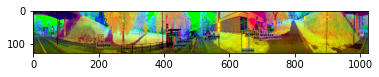

In [8]:

image = (sample["image"] * image_std + image_mean)
image = (image*255).byte()[0]
boxes = sample["boxes"][0]
boxes[:, [0, 2]] *= image.shape[-1]
boxes[:, [1, 3]] *= image.shape[-2]
im = image.permute(1, 2, 0).cpu().numpy()
im = draw_boxes(im, boxes.cpu().numpy(), sample["labels"][0].cpu().numpy().tolist(), class_name_map=cfg.label_map)


plt.imshow(im)
plt.show()